# Estimation des hyperparamètres - EM - VBEM

Dans ce notebook, on s'intéresse à un modèle simple
$$y = Ax + b$$
où $b$ est une bruit gaussien centré de matrice de covariance $\sigma_b^2 I$, et $x$ un signal à reconstruire, suivant une loi normale centrée de matrice de covariance $I / \tau$. Le paramètre $\tau$ sera également estimé.


In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt

In [2]:
def generate_data(A, sigma_n, alpha, beta):
    
    tau = rand.gamma(alpha, 1/beta)
    
    x = rand.multivariate_normal(np.zeros([A.shape[1]]), np.eye(A.shape[1]) / tau);
    b = rand.multivariate_normal(np.zeros([A.shape[0]]), np.eye(A.shape[0]) * sigma_n);
    y = A @ x + b
    
    return y, x, tau

In [3]:
def sample_tau(x, y, alpha, beta):
    """
    Loi a posteriori de tau | x
    """
    alpha2 = alpha + x.shape[0] / 2
    beta2 = beta + np.sum(x**2) / 2

    tau = rand.gamma(alpha2, 1/beta2)
    
    return tau


def sample_x(y, tau, A, sigma_n):
    """
    Loi a posteriori de x | y, tau
    """
    
    Reap = np.linalg.inv(A.T @ A / sigma_n + tau * np.eye(A.shape[1]))
    Xeap = Reap @ A.T @ y / sigma_n
    
    x = rand.multivariate_normal(Xeap, Reap);
    
    return x

def gibbs(y, A, alpha, beta, sigma_n, x0, tau0, q, L):

    
    Xsamples = np.zeros([x0.shape[0], L])
    Tausamples = np.zeros([L])
    
    Xsamples[:, 0] = x0
    Tausamples[0] = tau0
    
    for k in range(1,L):
        if rand.rand(1) > q:
            Xsamples[:, k] = sample_x(y, Tausamples[k-1], A, sigma_n)
            Tausamples[k] = Tausamples[k-1]
        else:
            Tausamples[k] = sample_tau(Xsamples[:, k-1], y, alpha, beta)
            
            Xsamples[:, k] = Xsamples[:, k-1]
    
    
    return Xsamples, Tausamples

In [4]:
N = 30;

A = rand.randn(N, N)

sigma_n = 0.1
alpha = 0.5
beta = 0.5
y, x, tau = generate_data(A, sigma_n, alpha, beta)

## EM

**Question 1** : mettre en oeuvre l'algorithm EM pour l'estimation du paramètre $\tau$. Donner son estimation MAP marginal et une estimation de $x$.

In [5]:
def EM(y, A, sigma_n, alpha, beta, niter):
    
    tau = alpha / beta; # tau est initializer par la moyenne selon sa loi gamma (beta, alpha)
    
    N = A.shape[1]
    
    for n in range(niter):
        C_chap = np.linalg.inv(A.T @ A / sigma_n + tau * np.eye(A.shape[1]))
        X_chap = C_chap @ A.T @ y / sigma_n
        tau = (alpha  + N/2 - 1) / (beta + (sum(X_chap **2) + np.trace(C_chap)))
    return tau

## VBEM

**Question 2** : mettre en oeuvre VBEM, et donner les paramètres des lois maringales approximatives de $\tau$ et $x$.

In [30]:
def VBEM(y, A, sigma_n, alpha, beta, niter):
    
    alphapost = alpha;
    betapost = beta;
    N = A.shape[1]
       
    
    for n in range(niter):
        # itération sur x
        taumean = alphapost/betapost;
        Rpost = np.linalg.inv(A.T @ A / sigma_n + taumean * np.eye(A.shape[1]))
        Xpost = Rpost @ A.T @ y / sigma_n
        
        # itération sur tau
        
        alphapost = alpha + N/2
        betapost = beta + (np.sum(Xpost**2) + np.trace(Rpost))/2
        
    return alphapost, betapost, Xpost, Rpost

In [31]:
alphapost, betapost, Xpost, Rpost = VBEM(y, A, sigma_n, alpha, beta, 100);

**Question 3** : sur un même graphique, tracer l'histogramme des échantillons de $\tau$ obtenus par l'échantillonneur de Gibbs, la valeur $\tau$ obtenue par EM, et la distribution a posteriori de $\tau$ donnée par VBEM.

In [33]:
# Now let's display all the found results 
niter = 10_000

# GIBBS
Xsamples, Tausamples = gibbs(y, A, alpha, beta, sigma_n, np.random.randn(N), 1, 0.5, niter)

# EM
tau_em = EM(y, A, sigma_n, alpha, beta, niter)
# Now we can estimate x 
Reap_em = np.linalg.inv(A.T @ A / sigma_n + tau_em * np.eye(A.shape[1]))
x_em = Reap_em @ A.T @ y / sigma_n

# VBEM
alpha_vbem, beta_vbem, Xeap, Reap = VBEM(y, A, sigma_n, alpha, beta, niter)


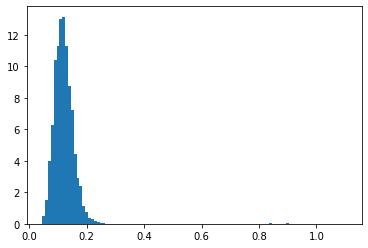

In [37]:
n, bins, patches = plt.hist(Tausamples , bins = np.arange(min(Tausamples), max(Tausamples) + 0.01, 0.01), density = True)

c:\Users\zakar\anaconda3\envs\deep_learning_iot\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
c:\Users\zakar\anaconda3\envs\deep_learning_iot\lib\site-packages\scipy\stats\_continuous_distns.py:2664: RuntimeWarning: invalid value encountered in subtract
  return sc.xlogy(a-1.0, x) - x - sc.gammaln(a)
c:\Users\zakar\anaconda3\envs\deep_learning_iot\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


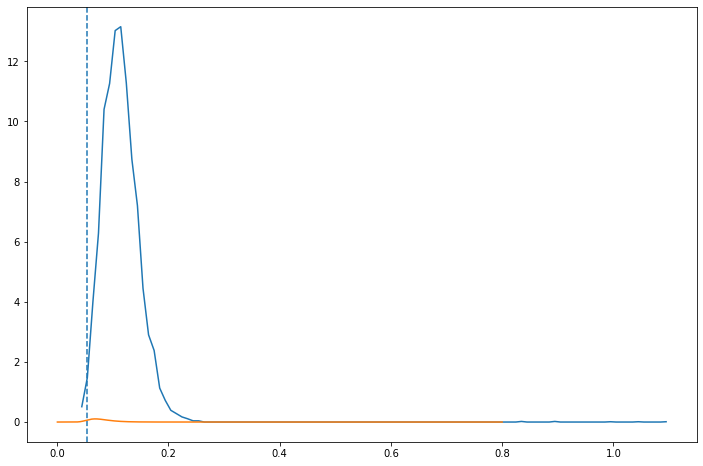

In [38]:
# Plotting the results 
from scipy.stats import gamma
dist = gamma(alpha_vbem, 1/beta_vbem)
x = np.linspace(0,0.8,1000)
pdf = dist.pdf(1/np.linspace(0,0.8,1000))

fig, ax = plt.subplots(1,1,figsize = (12,8))

# Calculate the width of each bin
width = 0.01

# Normalize the histogram values
n_normalized = n / (sum(n) * width)

# Plot the normalized histogram
plt.plot(bins[:-1], n_normalized)
ax.axvline(x=tau_em, linestyle='--')
ax.plot(x, pdf)
fig.show()